# Value based computations


In [1]:
#| default_exp explore

In [2]:
#| export
import numpy as np
from graphviz import Digraph
import math

In [3]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{%s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [47]:
#| export 
class Value:
    
    def __init__(self, data: float, _prev:set=(), _op: str='', label='') -> None:
        self.data = data
        self._prev = _prev
        self._backward = lambda: None
        self._op = _op
        self.label = label
        self.grad: float = 0.
        
    def __repr__(self) -> str:
        return f"Value({self.data = }, {self.grad=}, {self.label = })"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else (Value(other))
        out = Value(self.data + other.data, _prev=(self,other),_op='+')
        
        def _backward():
            # we do += to manage the case where we add with itself and it overrides the gradient. So we always add grad. 
            self.grad += 1. * out.grad
            other.grad += 1. * out.grad
        out._backward = _backward
        
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __neg__(self):
        return self *-1
    
    def __sub__(self, other):
        return self + (-other)
        
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else (Value(other))
        out =  Value(self.data * other.data, _prev=(self,other),_op='*')
    
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad            
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        return self * (other**-1)
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Other should be either int or float"
        out = Value(self.data**other, _prev=(self,), _op='**')
        
        def _backward():
            self.grad += other * (self.data**(other-1)) * out.grad
            
        out._backward = _backward
        
        return out
        
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), _prev=(self,), _op='exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out
        
        
    
    def tanh(self):
        x = self.data
        n = (1-math.exp(-2*x))/(1+math.exp(-2*x))
        out = Value(n, _prev=(self,), _op='tanh')
        
        def _backward():
            self.grad += (1-n**2) * out.grad
        
        out._backward = _backward
        
        return out
    
    
    
    
    def backward(self):
        topo = []
        visited = set()

        def build_topo(node: Value):
            if node not in visited:
                visited.add(node)
                for prev in node._prev:
                    build_topo(prev)
                topo.append(node)

        build_topo(self) 
        topo  
        self.grad = 1.
        for node in reversed(topo):
            node._backward()

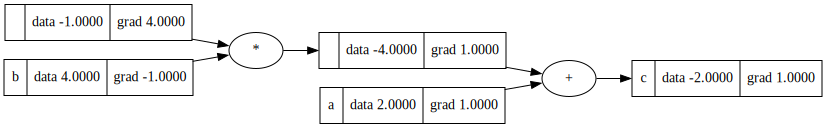

In [48]:
a = Value(2., label='a')
b = Value(4., label='b')
#a+1
#a*2
2*a
#1*a
#1+a
#a.exp()
#a/b
c=a-b; c.label='c'

c.backward()
draw_dot(c)

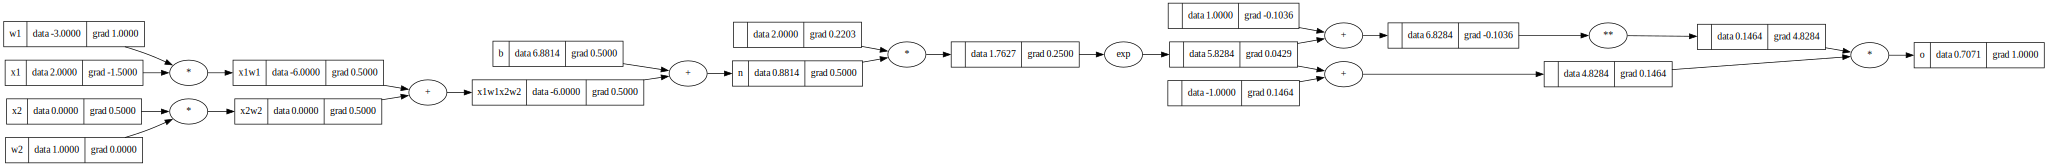

In [49]:
x1 = Value(2., label='x1')
x2 = Value(0., label='x2')

w1 = Value(-3., label='w1')
w2 = Value(1, label='w2')

x1w1 = x1 * w1; x1w1.label='x1w1'
x2w2 = x2 * w2; x2w2.label='x2w2'
b = Value(6.8813735870195432, label='b')
x1w1x2w2= x1w1 + x2w2; x1w1x2w2.label='x1w1x2w2'
n = x1w1x2w2+b; n.label='n'
e = (2*n).exp()
o = (e-1)/(e+1)
#o = n.tanh()
o.label = 'o'


#o.grad = 1.
#o._backward()
#n._backward()
#x1w1x2w2._backward()
#x1w1._backward()
##b._backward()
#x2w2._backward()
#x2._backward()
o.backward()
draw_dot(o)


In [32]:
topo = []
visited = set()

def build_topo(node: Value):
    if node not in visited:
        visited.add(node)
        for prev in node._prev:
            build_topo(prev)
        topo.append(node)
        
build_topo(x2w2)
topo

[Value(self.data = 0.0, self.grad=0.4999999999999999, self.label = 'x2'),
 Value(self.data = 1, self.grad=0.0, self.label = 'w2'),
 Value(self.data = 0.0, self.grad=0.4999999999999999, self.label = 'x2w2')]

In [ ]:
a = Value(3., label='a')
b = a + a; b.label = 'b'

b.backward()    
draw_dot(b)    

In [ ]:
a = Value(-2., label='a')
b = Value(3., label='b')
d = a*b; d.label='d'
e = a+b; e.label='e'
f = d*e; f.label='f'

f.backward()
draw_dot(f)

In [ ]:
import torch
def fit_polynomial(D, x, y):
    # Broadcasting magic
    X = x[:, None] ** torch.arange(0, D + 1)[None]
    # Least square solution
    return torch.linalg.lstsq(X, y).solution

D, N = 4, 100
x = torch.linspace(-math.pi, math.pi, N)
y = x.sin()
alpha = fit_polynomial(D, x, y)
X = x[:, None] ** torch.arange(0, D + 1)[None]
y_hat = X @ alpha
#for k in range(N):
#    print(x[k].item(), y[k].item(), y_hat[k].item())

In [ ]:
X